# **Evaluation de commentaires**
## Thêmes abordés
* data correction
* split train-dev-test
* embedding
* one hot encoder
* LTSM GRU
* data visualization

In [2]:
from utils2 import * 
import tensorflow as tf
%load_ext tensorboard
from tensorboard.plugins import projector
import tensorboard
from tensorflow import keras
import pandas as pd
import numpy as np
import emoji
%matplotlib inline
import matplotlib.pyplot as plt

assert tf.__version__ >= "2.0"

np.random.seed(0)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# **Pistes de travail**

* Tester tensorBoard pour visualiser loss/accuracy/other...
* Automatiser fine-tuning hyperparameters (dichotomie peut-être, keras tuner)
* #### Séparer chaque les commentaire en phrase, chaque phrase à la note du commentaire plus un champ correspondant au numéro du comm. Le but est d'éviter d'avoir trop de disparité de longueur entre les commentaire

In [4]:
# Data paths
EMBEDDING_PATH = "./data/glove.6B.50d.txt"
COMMENT_PATH = "./data/tripadvisor_hotel_reviews.csv"

# Data path after split and save
TRAIN_PATH = "./data/train_set.csv"
DEV_PATH = "./data/dev_set.csv"
TEST_PATH ="./data/test_set.csv"

# Global variable
VOCAB_SIZE = 10000
NUM_OOV_BUCKETS = 1000

### Première piste de pré traitement
* Ajout d'une colonne correspondant à la longueur du commentaire 
* Catégorisation des longueurs en intervalles

In [3]:
# Load embedding
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(EMBEDDING_PATH)

In [4]:
# Load data
dataset = pd.read_csv(COMMENT_PATH)
dataset_numpy = np.array(dataset)

In [5]:
# Création d'esapce entre les ponctuation en les mots
for comment, rating in dataset_numpy:
    comment = ponctuation_padding(comment)

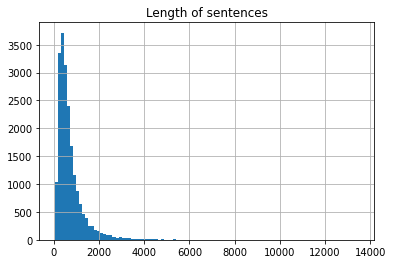

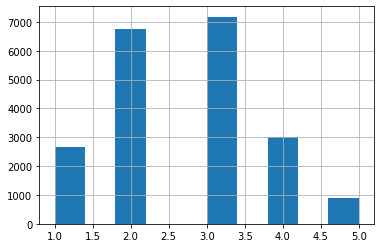

       Length of sentences
count         20491.000000
mean            724.896882
std             689.101093
min              44.000000
25%             339.000000
50%             537.000000
75%             859.000000
max           13501.000000


In [49]:
dataset_of_length = pd.DataFrame([len(comment[0]) for comment in dataset_numpy], columns=['Length of sentences'])
dataset_of_length.hist(bins=100)
plt.show()
dataset["comments_length"] = dataset_of_length
dataset["length_cat"] = pd.cut(dataset["comments_length"], 
                               bins = [0, 250, 500, 1000, 2000, np.inf],
                              labels = [1, 2, 3, 4, 5])
dataset["length_cat"].hist()
plt.show()
print(dataset_of_length.describe())

In [51]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

# Stratified split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in split.split(dataset, dataset["length_cat"]):
    strat_train_set = dataset.loc[train_index]
    strat_test_set = dataset.loc[test_index]

#Random split
rand_train_set, rand_test_set = train_test_split(dataset, test_size=0.2, random_state=0)

In [ ]:
print("Stratified split repartition:\n",
      strat_test_set["length_cat"].value_counts() / len(strat_test_set)*100,
      "\nRandom split repartition:\n",
      rand_test_set["length_cat"].value_counts() / len(rand_test_set)*100,
      "\Initial repartition:\n",
      dataset["length_cat"].value_counts() / len(dataset)*100)

In [52]:
train_set, test_set = strat_train_set, strat_test_set

### Seconde piste de pré traitement
* Limitation de la taille des commentaire
* Suppression de la ponctuation

#### Séparation et sauvegarde des différents jeux de données

***Cette partie peut être sautée si les fichier sont déjà sauvegardés***

In [77]:
from sklearn.model_selection import train_test_split

# Load data
dataset = pd.read_csv(COMMENT_PATH)
dataset.info()

# Split Train Dev Test

train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=0)
dev_set, test_set = train_test_split(test_set, test_size=0.5, random_state=0)

# Save split data set
train_set.to_csv("./data/train_set.csv", sep=";", columns =["Review", "Rating"])
dev_set.to_csv("./data/dev_set.csv", sep=";", columns =["Review", "Rating"])
test_set.to_csv("./data/test_set.csv", sep=";", columns =["Review", "Rating"])

In [76]:
data = pd.read_csv(TRAIN_PATH, delimiter = ";")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16392 entries, 0 to 16391
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  16392 non-null  int64 
 1   Review      16392 non-null  object
 2   Rating      16392 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 384.3+ KB


#### Chargement et prétraitement

In [5]:
def csv_reader_dataset(filepath):
    """load data frame and convert to tf tensor"""
    dataset = pd.read_csv(filepath,delimiter = ";")
    review, rating = np.array(dataset["Review"]), np.array(dataset["Rating"])
    data = tf.data.Dataset.from_tensor_slices((review, rating))
    return data

In [6]:
def preprocess(X_batch, y_batch):
    """ limit size of comments to 300
    only keep letters and quotes
    split and pad with <pad>"""
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, b"<\\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    y_batch = tf.one_hot(y_batch, 5, on_value=1.0, off_value = 0.0)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

#### Construction du vocabulaire


In [7]:
from collections import Counter

train_dataset = csv_reader_dataset(TRAIN_PATH)

vocabulary = Counter()

for X_batch, y_batch in train_dataset.batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))
        
print(vocabulary.most_common()[:10])

[(b'<pad>', 134397), (b'hotel', 22746), (b'room', 13758), (b'great', 9901), (b'not', 8767), (b'staff', 7078), (b'stayed', 6824), (b'location', 6479), (b'stay', 6152), (b'good', 6044)]


In [8]:
# Keep the first *VOCAB SIZE* words
truncated_vocab = [word for word, count in vocabulary.most_common()[:VOCAB_SIZE]]
words = tf.constant(truncated_vocab)

In [9]:
# Words to id
word_id = tf.range(len(truncated_vocab), dtype = tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_id)
table = tf.lookup.StaticVocabularyTable(vocab_init, NUM_OOV_BUCKETS)

In [10]:
table.lookup(tf.constant([b"This restaurant was greeat".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[10745,    93,  2786, 10300]])>

Pour aller plus loin : regarder tft.compute_and_apply_vocaulary()

In [11]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

In [12]:
train_set = train_dataset.batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

dev_set = csv_reader_dataset(DEV_PATH)
dev_set = dev_set.batch(32).map(preprocess)
dev_set = dev_set.map(encode_words).prefetch(1)

In [13]:
embed_size = 128

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

model = keras.models.Sequential([
    keras.layers.Embedding(VOCAB_SIZE + NUM_OOV_BUCKETS,
                           embed_size, 
                           input_shape=[None],
                          mask_zero = True),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(5, activation="softmax")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, 
                    epochs=5,
                    validation_data=dev_set, 
                    callbacks=[tensorboard_callback]
                   )

Epoch 1/5
  1/513 [..............................] - ETA: 0s - loss: 0.3792 - accuracy: 0.1875WARNING:tensorflow:From /home/thibault/Documents/ml/my_env/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
513/513 [==============================] - 71s 138ms/step - loss: 0.3070 - accuracy: 0.3324 - val_loss: 0.2903 - val_accuracy: 0.3548
Epoch 2/5
513/513 [==============================] - 66s 129ms/step - loss: 0.2687 - accuracy: 0.3919 - val_loss: 0.3021 - val_accuracy: 0.3363
Epoch 3/5
513/513 [==============================] - 68s 132ms/step - loss: 0.2291 - accuracy: 0.4580 - val_loss: 0.3384 - val_accuracy: 0.3182
Epoch 4/5
513/513 [==============================] - 68s 132ms/step - loss: 0.1980 - accuracy: 0.4988 - val_loss: 0.3857 - val_accuracy: 0.3094
Epoch 5/5
513/513 [===================

In [14]:
%tensorboard --logdir logs

In [15]:
weights = model.get_layer('embedding').get_weights()[0]
print(weights.shape) 

(11000, 128)


In [27]:
import io

out_v = io.open('./logs/vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('./logs/meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(vocabulary.most_common()[:VOCAB_SIZE + NUM_OOV_BUCKETS]):
    if num == 0: continue # skip padding token from vocab
    vec = weights[num]
    out_m.write(str(word) + str("\n"))
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download('vecs.tsv')
    files.download('meta.tsv')


In [30]:
# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'meta.tsv'
projector.visualize_embeddings('./logs/tripAdvisor-example', config)


%tensorboard --logdir /logs/tripAdvisor-example/

Reusing TensorBoard on port 6007 (pid 18041), started 0:07:31 ago. (Use '!kill 18041' to kill it.)

In [12]:
dev_set = csv_reader_dataset(DEV_PATH)
dev_set = dev_set.batch(32).map(preprocess)
dev_set = dev_set.map(encode_words).prefetch(1)

loss, acc = model.evaluate(dev_set)

print()
print("Test accuracy = ", acc)

65/65 [==============================] - 2s 25ms/step - loss: 0.4008 - accuracy: 0.3119

Test accuracy =  0.3118594288825989


In [15]:
dev_dataset = pd.read_csv(DEV_PATH, delimiter=";")
review, rating = dev_dataset["Review"], dev_dataset["Rating"]

pred = model.predict(dev_set)

miss_match = 0
one_difference = 0
for i in range(len(review)):
    num = np.argmax(pred[i])
    if(abs(num - rating[i]) >= 2):
        print(review[i])
        print(emoji.emojize(':orange_heart:')*(num), 
              '=/=',emoji.emojize(':green_heart:')*(rating[i])
             )
        miss_match = miss_match +1
    elif abs(num - rating[i]) == 1:
        one_difference +=1
print('miss match = ' , miss_match,  "/" , len(review))
print('one star difference = ' , one_difference,  "/" , len(rating))

perfect wedding paradisus palma real husband got married july 13th 2007 paradisus palma real punta cana, happy chose destination wedding palma real, kelly hunt wedding coordinator did exceptional job w not staff palma real dominican professional really outdid, 60 guests come wedding amazed nice wedding turned, food reception great added dancers honeymooned planning return, highly recommend planning destination wedding palma real contact kelly, wo n't regret,  
🧡 =/= 💚💚💚💚💚
not n't want good location pretty quiet canal generous breakfasts brought friendly hosts spacious high-ceilinged room 5 large bathroom shower meets husband high standards spray temperature n't place, people wanting perfect decor communal breakfasts meet fellow travelers disappointed, actually ended room enjoyed 10 years ago.advice used taxi train station tries charge 20 euros report number hosts, n't 12 euros,  
🧡🧡🧡 =/= 💚💚💚💚💚
not ready prime time stayed resort week april 5. resort 50 open romms, main areas completed a

ciao thank hospitality, just wanted say appreciated lombardi kindness family stayed hotel april, hospitality helpfulness graciousness helped adjust new environment, impressed languages speak fluently, recommend hotel casci know like great place stay florence,  
🧡 =/= 💚💚💚💚💚
randy best, randy best, ask definitely care you.this boutique hotel middle downtown walking distance sf.the rooms great service better.if looking place need sf make place,  
🧡🧡 =/= 💚💚💚💚💚
loved inn husband wanted romantic away night, inn perfect met imagined, rooms clean quiet comfortable bath robes nice touch, staff helpful, location great good restaurants walking distance market right fun visit time free bus service close visit sites city, beware parking hotel valet costs 25.00 night, mentioned desk person not away cost not mentioned web page, expected pay removed charge, great customer service, wonderful deck overlooking puget sound, recommend inn planning long visit just romantic away,  
🧡 =/= 💚💚💚💚💚
best kept secr

In [18]:
import os

# Set up a logs directory, so Tensorboard knows where to look for files
log_dir='./logs/tripAdvisor-example/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for subwords in table.subwords:
        f.write("{}\n".format(subwords))
      # Fill in the rest of the labels with "unknown"
    for unknown in range(1, table.vocab_size - len(table.subwords)):
        f.write("unknown #{}\n".format(unknown))


# Save the weights we want to analyse as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, so
# we will remove that value.
weights = tf.Variable(model.layers[0].get_weights()[0][1:])
# Create a checkpoint from embedding, the filename and key are
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)


AttributeError: 'StaticVocabularyTable' object has no attribute 'subwords'